In [1]:
import networkx as nx
import numpy as np
rd = np.random
import itertools as it
import knee.rdp as rdp
import knee.kneedle as kneedle

import time

from thresholding import *
from weight_computer import *

from castle.common import GraphDAG, independence_tests
from castle.metrics import MetricsDAG
from castle.algorithms import PC

import matplotlib.pyplot as pl
import pandas as pd
#font = {'size'   : 11}

#import matplotlib
#matplotlib.rc('font', **font)

2024-03-13 16:14:53,074 - /home/filipe/anaconda3/envs/pythenv39/lib/python3.9/site-packages/castle/backend/__init__.py[line:36] - INFO: You can use `os.environ['CASTLE_BACKEND'] = backend` to set the backend(`pytorch` or `mindspore`).
2024-03-13 16:14:53,247 - /home/filipe/anaconda3/envs/pythenv39/lib/python3.9/site-packages/castle/algorithms/__init__.py[line:36] - INFO: You are using ``pytorch`` as the backend.


## NETWORK

In [2]:
#'''
dft = pd.read_csv("DAGtrue_ASIA.csv")
df = pd.read_csv("ASIA_DATA.csv")
'''
df = pd.read_csv("ALARM_DATA.csv")
dft = pd.read_csv("DAGtrue_ALARM.csv")
#'''

DAGt = nx.DiGraph()
DAGt.add_edges_from(np.array(dft[['Variable 1','Variable 2']]))
Gt = nx.to_undirected(DAGt)

states = {node:list(df[node].unique()) for node in df.columns}
order = {node:np.where(node==np.array(list(nx.topological_sort(DAGt))))[0][0] for node in list(states)}
pos={i:(order[i],(rd.random())-0.5) for i in order}

X = np.array(df)

n_nodes = len(df.columns)
node_list = df.columns

true_matrix=nx.adjacency_matrix(DAGt,nodelist=list(states)).toarray()
true_skeleton=nx.adjacency_matrix(Gt,nodelist=list(states)).toarray()
for k,j in it.product(range(n_nodes),repeat=2): #removes bottom half of matrix
    if k>=j: true_skeleton[k,j]=0

a = np.zeros(np.shape(X))
i=0
for col in df:
    #print(df[col])
    j=0
    for st in states[col]:
        a[:,i][np.where(df[col]==st)]=j
        j+=1
    i+=1

print("n",n_nodes)
print("k",np.mean(list(dict(DAGt.in_degree).values())))

n 8
k 1.0


## PC Algorithm

t(s) 5.165944129
FPR 0.05357142857142857
FNR 0.125
MCC 0.7481900559272088


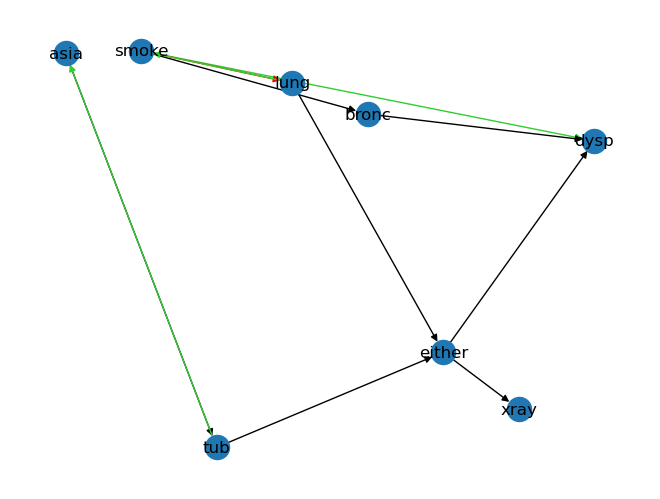

t(s) 1.24931576
FPR 0.05
FNR 0.0
MCC 0.9189365834726815


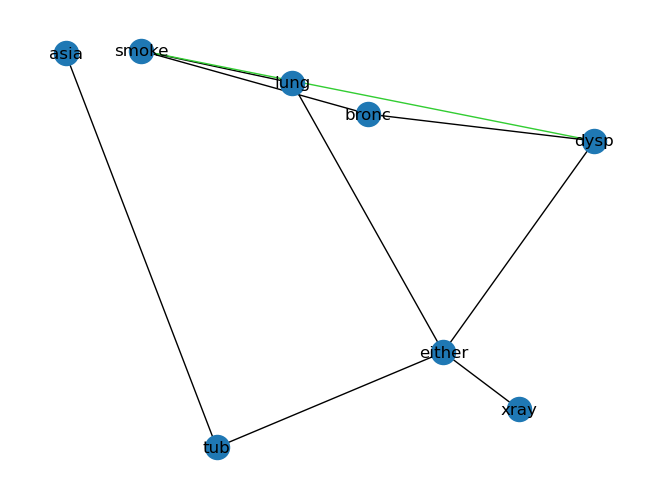

In [3]:
# PC algorithm
pc_time = time.process_time()
pc = PC(alpha=0.05)
pc.learn(a)
pc_time = time.process_time() - pc_time

FN = int(np.sum((true_matrix-pc.causal_matrix)>0)) #False Negatives
FP = int(np.sum((true_matrix-pc.causal_matrix)<0)) #False Positives
TP = len(DAGt.edges) - FN #True Positives = P - FN
TN = (n_nodes*n_nodes - len(DAGt.edges))-FP #True Negatives = N-FP

print("t(s)", pc_time)

print("FPR", FP/(n_nodes*n_nodes - len(DAGt.edges)) ) #FPR = FP/N
print("FNR", FN/len(DAGt.edges) ) #FNR = FN/P
print("MCC", (TP*TN - FP*FN)/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)) ) #MCC

DAGf = nx.DiGraph()
DAGf.add_edges_from(np.array(np.where(pc.causal_matrix == 1)).T,color="k")
DAGf = nx.relabel_nodes(DAGf,{i:node_list[i] for i in range(len(node_list))})

Gf = DAGf.to_undirected()

to_remove = DAGf.edges() - DAGt.edges()
DAGf.remove_edges_from( to_remove )
DAGf.add_edges_from( to_remove ,color="limegreen") #excess
DAGf.add_edges_from(list(DAGt.edges() - DAGf.edges()) ,color="r") #missing

colors = [DAGf[u][v]['color'] for u,v in DAGf.edges()]
nx.draw(DAGf,pos=pos,edge_color=colors,with_labels=True)
pl.show()

#Skeleton
pc_skeletime = time.process_time()
skeleton = find_skeleton(a, 0.05, "fisherz")[0]
pc_skeletime = time.process_time() - pc_skeletime
for k,j in it.product(range(n_nodes),repeat=2): #removes bottom half of matrix
    if k>=j: skeleton[k,j]=0

FN = int(np.sum((true_skeleton-skeleton)>0)) #False Negatives
FP = int(np.sum((true_skeleton-skeleton)<0)) #False Positives
TP = len(Gt.edges) - FN #True Positives = P - FN
TN = (n_nodes*(n_nodes-1)/2 - len(Gt.edges))-FP #True Negatives = N-FP

print("t(s)", pc_skeletime)

Gf = nx.Graph()
Gf.add_edges_from(np.array(np.where(skeleton == 1)).T,color="k")
Gf = nx.relabel_nodes(Gf,{i:node_list[i] for i in range(len(node_list))})

to_remove = Gf.edges() - Gt.edges()
Gf.remove_edges_from( to_remove )
Gf.add_edges_from( to_remove ,color="limegreen") #excess
Gf.add_edges_from(list(Gt.edges() - Gf.edges()) ,color="r") #missing

print("FPR", FP/(n_nodes*(n_nodes-1)/2 - len(Gt.edges)) ) #FPR = FP/N
print("FNR", FN/len(Gt.edges) ) #FNR = FN/P
print("MCC", (TP*TN - FP*FN)/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)) ) #MCC

colors = [Gf[u][v]['color'] for u,v in Gf.edges()]
nx.draw(Gf,pos=pos,edge_color=colors,with_labels=True)

## FisherConnected

T(s) 0.6664609000000006 0.12901047385679162
FPR 0.10714285714285714
FNR 0.75
MCC 0.14285714285714285


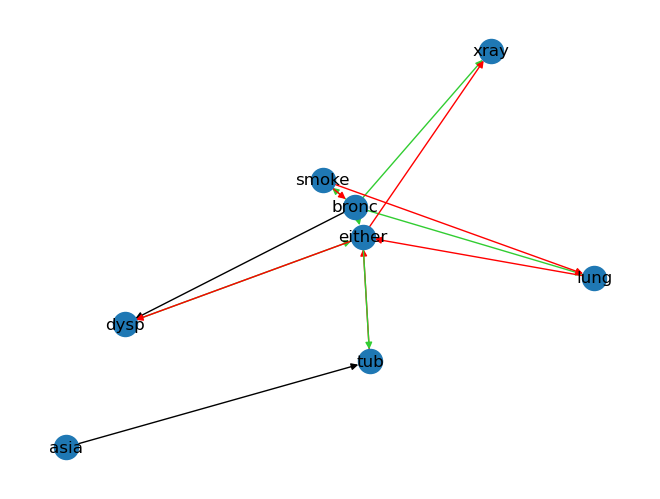

In [4]:
algtime = time.process_time()
key = {node_list[i]:i for i in range(len(node_list))}
fish_vals = [independence_tests.CITest.fisherz_test(a,key[x],key[y],[])[2] for x,y in it.permutations(node_list,2)]
fish_vars = [(x,y) for x,y in it.permutations(node_list,2)]

unique_edges, unique_vals = (lambda x: (np.array(fish_vars)[x], np.array(fish_vals)[x]))(np.argsort(fish_vals))
unique_edges, unique_vals = np.flip(unique_edges,axis=0), np.flip(unique_vals,axis=0)

m = binary_search(node_list, unique_edges)
thres = unique_vals[m]

DAG_w1 = nx.DiGraph()
DAG_w1.add_edges_from(unique_edges[m:])

DAG_w2 = triangulation_fisher(a, node_list, unique_edges[m:], thres)
algtime = time.process_time() - algtime

print("T(s)",algtime,algtime/pc_time)

FN = len(DAGt.edges-DAG_w2.edges) #False Negatives
FP = len(DAG_w2.edges-DAGt.edges) #False Positives
TP = len(DAGt.edges) - FN #True Positives = P - FN
TN = (n_nodes*n_nodes - len(DAGt.edges))-FP #True Negatives = N-FP

print("FPR", FP/(n_nodes*n_nodes - len(DAGt.edges)) ) #FPR = FP/N
print("FNR", FN/len(DAGt.edges) ) #FNR = FN/P
print("MCC", (TP*TN - FP*FN)/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)) ) #MCC

G = nx.DiGraph()
G.add_edges_from(DAG_w2.edges,color="k")

were_removed = DAG_w1.edges - DAG_w2.edges #excess removed in 1st step
to_remove = G.edges() - DAGt.edges()
G.remove_edges_from( to_remove )
G.add_edges_from( to_remove ,color="limegreen") #excess
G.add_edges_from( were_removed ,color="gray") #excess removed
G.add_edges_from(list(DAGt.edges() - G.edges()) ,color="r") #missing

colors = [G[u][v]['color'] for u,v in G.edges()]
#pl.figure(figsize=(20,16))
nx.draw(G,edge_color=colors,with_labels=True)

T(s) 0.6753288990000001 0.1307271008234321
FPR 0.05357142857142857
FNR 0.25
MCC 0.6625413488689132


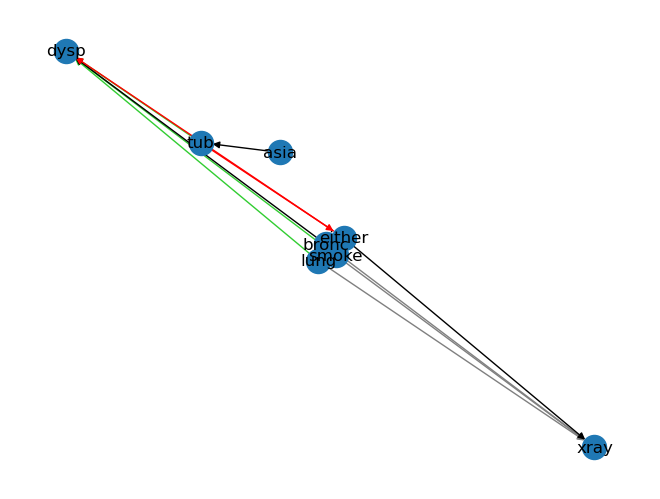

In [5]:
algtime = time.process_time()
key = {node_list[i]:i for i in range(len(node_list))}
fish_vals = [independence_tests.CITest.fisherz_test(a,key[x],key[y],[])[2] for x,y in it.permutations(node_list,2) if order[x]<order[y]]
fish_vars = [(x,y) for x,y in it.permutations(node_list,2) if order[x]<order[y]]

unique_edges, unique_vals = (lambda x: (np.array(fish_vars)[x], np.array(fish_vals)[x]))(np.argsort(fish_vals))
unique_edges, unique_vals = np.flip(unique_edges,axis=0), np.flip(unique_vals,axis=0)

m = binary_search(node_list, unique_edges)
thres = unique_vals[m]

DAG_w1 = nx.DiGraph()
DAG_w1.add_edges_from(unique_edges[m:])

DAG_w2 = triangulation_fisher(a, node_list, unique_edges[m:], thres)
algtime = time.process_time() - algtime

print("T(s)",algtime,algtime/pc_time)

FN = len(DAGt.edges-DAG_w2.edges) #False Negatives
FP = len(DAG_w2.edges-DAGt.edges) #False Positives
TP = len(DAGt.edges) - FN #True Positives = P - FN
TN = (n_nodes*n_nodes - len(DAGt.edges)) - FP #True Negatives = N - FP

print("FPR", FP/(n_nodes*n_nodes - len(DAGt.edges)) ) #FPR = FP/N
print("FNR", FN/len(DAGt.edges) ) #FNR = FN/P
print("MCC", (TP*TN - FP*FN)/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)) ) #MCC

G = nx.DiGraph()
G.add_edges_from(DAG_w2.edges,color="k")

were_removed = DAG_w1.edges - DAG_w2.edges #excess removed in 1st step
to_remove = G.edges() - DAGt.edges()
G.remove_edges_from( to_remove )
G.add_edges_from( to_remove ,color="limegreen") #excess
G.add_edges_from( were_removed ,color="gray") #excess removed
G.add_edges_from(list(DAGt.edges() - G.edges()) ,color="r") #missing

colors = [G[u][v]['color'] for u,v in G.edges()]
#pl.figure(figsize=(20,16))
nx.draw(G,edge_color=colors,with_labels=True)

T(s) 1.0220104980000002 0.818056195817141
FPR 0.1
FNR 0.25
MCC 0.65


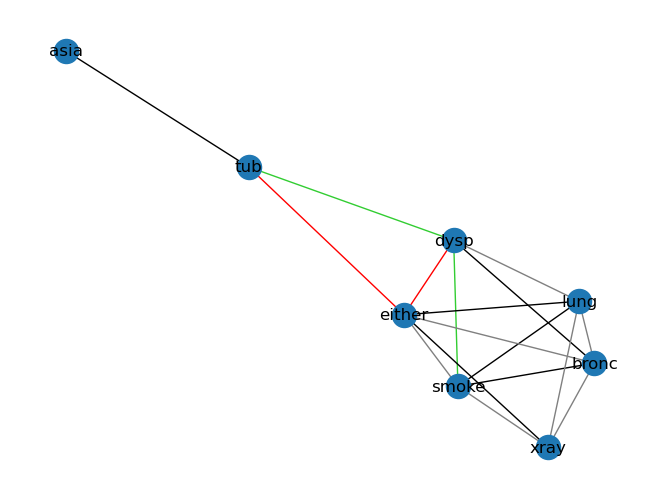

In [6]:
algtime = time.process_time()
key = {node_list[i]:i for i in range(len(node_list))}
fish_vals = [independence_tests.CITest.fisherz_test(a,key[x],key[y],[])[2] for x,y in it.combinations(node_list,2)]
fish_vars = [(x,y) for x,y in it.combinations(node_list,2)]

unique_edges, unique_vals = (lambda x: (np.array(fish_vars)[x], np.array(fish_vals)[x]))(np.argsort(fish_vals))
unique_edges, unique_vals = np.flip(unique_edges,axis=0), np.flip(unique_vals,axis=0)

m = binary_search(node_list, unique_edges)
thres = unique_vals[m]

DAG_w1 = nx.Graph()
DAG_w1.add_edges_from(unique_edges[m:])

DAG_w2 = triangulation_fisher_und(a, node_list, unique_edges[m:], thres)
algtime = time.process_time() - algtime

print("T(s)",algtime,algtime/pc_skeletime)

FN = len(Gt.edges-DAG_w2.edges) #False Negatives
FP = len(DAG_w2.edges-Gt.edges) #False Positives
TP = len(Gt.edges) - FN #True Positives = P - FN
TN = (int(n_nodes*(n_nodes-1)/2) - len(Gt.edges)) - FP #True Negatives = N - FP

print("FPR", FP/(n_nodes*(n_nodes-1)/2 - len(Gt.edges)) ) #FPR = FP/N
print("FNR", FN/len(Gt.edges) ) #FNR = FN/P
print("MCC", (TP*TN - FP*FN)/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)) ) #MCC

G = nx.Graph()
G.add_edges_from(DAG_w2.edges,color="k")

were_removed = DAG_w1.edges - DAG_w2.edges #excess removed in 1st step
to_remove = G.edges() - Gt.edges()
G.remove_edges_from( to_remove )
G.add_edges_from( to_remove ,color="limegreen") #excess
G.add_edges_from( were_removed ,color="gray") #excess removed
G.add_edges_from(list(Gt.edges() - G.edges()) ,color="r") #missing

colors = [G[u][v]['color'] for u,v in G.edges()]
#pl.figure(figsize=(20,16))
nx.draw(G,edge_color=colors,with_labels=True)

## FisherKnee

T(s) 0.6225404599999997 0.1205085545748069
FPR 0.10714285714285714
FNR 0.75
MCC 0.14285714285714285


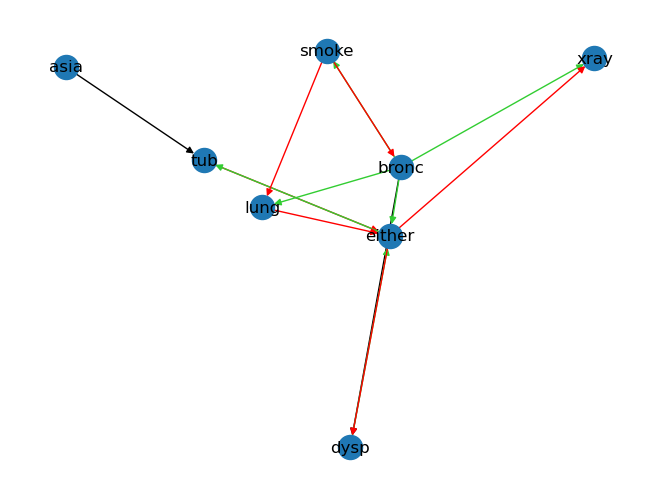

In [7]:
algtime = time.process_time()
key = {node_list[i]:i for i in range(len(node_list))}
fish_vals = [independence_tests.CITest.fisherz_test(a,key[x],key[y],[])[2] for x,y in it.permutations(node_list,2)]
fish_vars = [(x,y) for x,y in it.permutations(node_list,2)]

unique_edges, unique_vals = (lambda x: (np.array(fish_vars)[x], np.array(fish_vals)[x]))(np.argsort(fish_vals))
unique_edges, unique_vals = np.flip(unique_edges,axis=0), np.flip(unique_vals,axis=0)

gcc_nodes=np.zeros(len(unique_edges))
for j in range(len(unique_edges)):
    H = nx.Graph()
    H.add_edges_from(unique_edges[j:])
    gcc_nodes[j] = len(max(nx.connected_components(H),key=len))
del H
m = kneedle.auto_knee(np.column_stack((np.arange(len(gcc_nodes)),gcc_nodes)))
thres = unique_vals[m]

DAG_w1 = nx.DiGraph()
DAG_w1.add_edges_from(unique_edges[m:])

DAG_w2 = triangulation_fisher(a, node_list, unique_edges[m:], thres)
algtime = time.process_time() - algtime

print("T(s)",algtime,algtime/pc_time)

FN = len(DAGt.edges-DAG_w2.edges) #False Negatives
FP = len(DAG_w2.edges-DAGt.edges) #False Positives
TP = len(DAGt.edges) - FN #True Positives = P - FN
TN = (n_nodes*n_nodes - len(DAGt.edges)) - FP #True Negatives = N - FP

print("FPR", FP/(n_nodes*n_nodes - len(DAGt.edges)) ) #FPR = FP/N
print("FNR", FN/len(DAGt.edges) ) #FNR = FN/P
print("MCC", (TP*TN - FP*FN)/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)) ) #MCC

G = nx.DiGraph()
G.add_edges_from(DAG_w2.edges,color="k")

were_removed = DAG_w1.edges - DAG_w2.edges #excess removed in 1st step
to_remove = G.edges() - DAGt.edges()
G.remove_edges_from( to_remove )
G.add_edges_from( to_remove ,color="limegreen") #excess
G.add_edges_from( were_removed ,color="gray") #excess removed
G.add_edges_from(list(DAGt.edges() - G.edges()) ,color="r") #missing

colors = [G[u][v]['color'] for u,v in G.edges()]
#pl.figure(figsize=(20,16))
nx.draw(G,edge_color=colors,with_labels=True)

T(s) 0.6743741310000004 0.1305422811706914
FPR 0.05357142857142857
FNR 0.25
MCC 0.6625413488689132


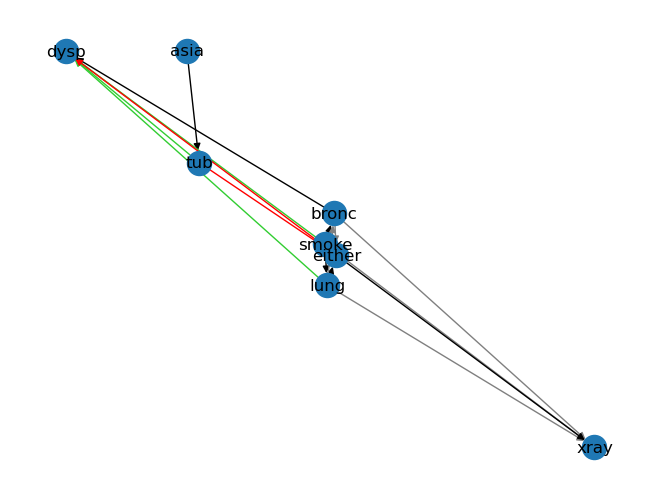

In [8]:
algtime = time.process_time()
key = {node_list[i]:i for i in range(len(node_list))}
fish_vals = [independence_tests.CITest.fisherz_test(a,key[x],key[y],[])[2] for x,y in it.permutations(node_list,2) if order[x]<order[y]]
fish_vars = [(x,y) for x,y in it.permutations(node_list,2) if order[x]<order[y]]

unique_edges, unique_vals = (lambda x: (np.array(fish_vars)[x], np.array(fish_vals)[x]))(np.argsort(fish_vals))
unique_edges, unique_vals = np.flip(unique_edges,axis=0), np.flip(unique_vals,axis=0)

gcc_nodes=np.zeros(len(unique_edges))
for j in range(len(unique_edges)):
    H = nx.Graph()
    H.add_edges_from(unique_edges[j:])
    gcc_nodes[j] = len(max(nx.connected_components(H),key=len))
del H
m = kneedle.auto_knee(np.column_stack((np.arange(len(gcc_nodes)),gcc_nodes)))
thres = unique_vals[m]

DAG_w1 = nx.DiGraph()
DAG_w1.add_edges_from(unique_edges[m:])

DAG_w2 = triangulation_fisher(a, node_list, unique_edges[m:], thres)
algtime = time.process_time() - algtime

print("T(s)",algtime,algtime/pc_time)

FN = len(DAGt.edges-DAG_w2.edges) #False Negatives
FP = len(DAG_w2.edges-DAGt.edges) #False Positives
TP = len(DAGt.edges) - FN #True Positives = P - FN
TN = (n_nodes*n_nodes - len(DAGt.edges)) - FP #True Negatives = N - FP

print("FPR", FP/(n_nodes*n_nodes - len(DAGt.edges)) ) #FPR = FP/N
print("FNR", FN/len(DAGt.edges) ) #FNR = FN/P
print("MCC", (TP*TN - FP*FN)/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)) ) #MCC

G = nx.DiGraph()
G.add_edges_from(DAG_w2.edges,color="k")

were_removed = DAG_w1.edges - DAG_w2.edges #excess removed in 1st step
to_remove = G.edges() - DAGt.edges()
G.remove_edges_from( to_remove )
G.add_edges_from( to_remove ,color="limegreen") #excess
G.add_edges_from( were_removed ,color="gray") #excess removed
G.add_edges_from(list(DAGt.edges() - G.edges()) ,color="r") #missing

colors = [G[u][v]['color'] for u,v in G.edges()]
#pl.figure(figsize=(20,16))
nx.draw(G,edge_color=colors,with_labels=True)

T(s) 0.9685664379999999 0.7752775311183138
FPR 0.08333333333333333
FNR 0.25
MCC 0.6666666666666666


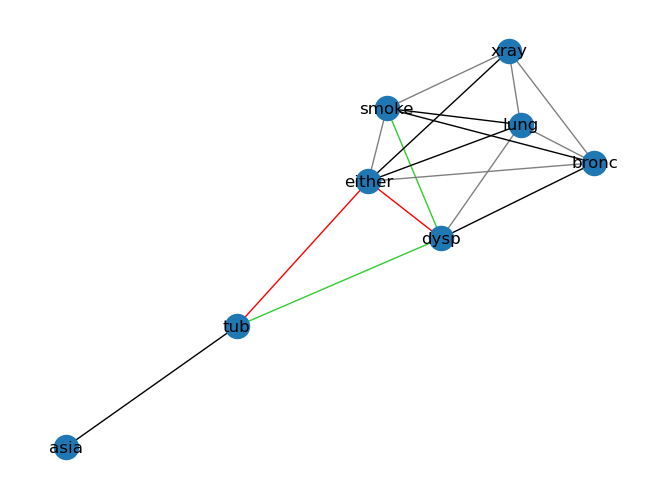

In [9]:
algtime = time.process_time()
key = {node_list[i]:i for i in range(len(node_list))}
fish_vals = [independence_tests.CITest.fisherz_test(a,key[x],key[y],[])[2] for x,y in it.combinations(node_list,2)]
fish_vars = [(x,y) for x,y in it.combinations(node_list,2)]

unique_edges, unique_vals = (lambda x: (np.array(fish_vars)[x], np.array(fish_vals)[x]))(np.argsort(fish_vals))
unique_edges, unique_vals = np.flip(unique_edges,axis=0), np.flip(unique_vals,axis=0)

gcc_nodes=np.zeros(len(unique_edges))
for j in range(len(unique_edges)):
    H = nx.Graph()
    H.add_edges_from(unique_edges[j:])
    gcc_nodes[j] = len(max(nx.connected_components(H),key=len))
del H
m = kneedle.auto_knee(np.column_stack((np.arange(len(gcc_nodes)),gcc_nodes)))
thres = unique_vals[m]

DAG_w1 = nx.Graph()
DAG_w1.add_edges_from(unique_edges[m:])

DAG_w2 = triangulation_fisher_und(a, node_list, unique_edges[m:], thres)
algtime = time.process_time() - algtime

print("T(s)",algtime,algtime/pc_skeletime)

FN = len(Gt.edges-DAG_w2.edges) #False Negatives
FP = len(DAG_w2.edges-Gt.edges) #False Positives
TP = len(Gt.edges) - FN #True Positives = P - FN
TN = (int(n_nodes*(n_nodes)/2) - len(Gt.edges)) - FP #True Negatives = N - FP

print("FPR", FP/(n_nodes*(n_nodes)/2 - len(Gt.edges)) ) #FPR = FP/N
print("FNR", FN/len(Gt.edges) ) #FNR = FN/P
print("MCC", (TP*TN - FP*FN)/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)) ) #MCC

G = nx.Graph()
G.add_edges_from(DAG_w2.edges,color="k")

were_removed = DAG_w1.edges - DAG_w2.edges #excess removed in 1st step
to_remove = G.edges() - Gt.edges()
G.remove_edges_from( to_remove )
G.add_edges_from( to_remove ,color="limegreen") #excess
G.add_edges_from( were_removed ,color="gray") #excess removed
G.add_edges_from(list(Gt.edges() - G.edges()) ,color="r") #missing

colors = [G[u][v]['color'] for u,v in G.edges()]
#pl.figure(figsize=(20,16))
nx.draw(G,edge_color=colors,with_labels=True)

## NIConnected

T(s) 3.420740246000001 0.6621713593062364
FPR 0.017857142857142856
FNR 0.125
MCC 0.8571428571428571


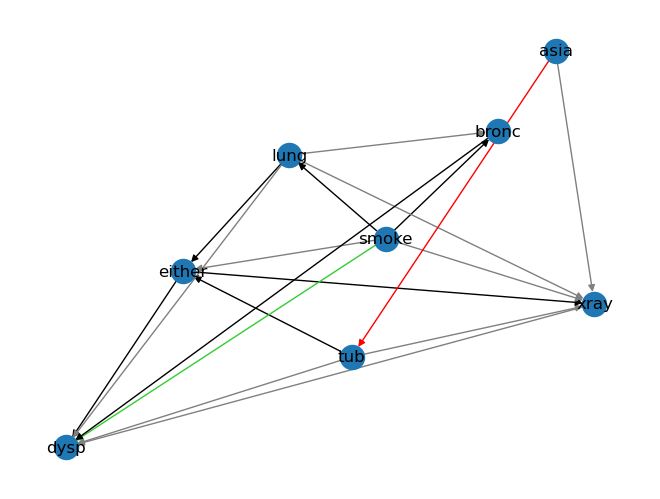

In [10]:
algtime = time.process_time()
weight_num_writer_ord(X, states, order)
wn_var = np.array(weight_var_importer('weights_num.txt'))
wn_val = np.array(weight_val_importer('weights_num.txt'))

unique_edges = np.unique(wn_var[:,:2],axis=0)
unique_vals = np.zeros(len(unique_edges))
for j in range(len(unique_edges)):
    pair = unique_edges[j]
    unique_vals[j] = (np.max( np.abs( wn_val[np.all(wn_var[:,:2]==pair,axis=1)]) ) )
unique_vals=np.abs(unique_vals)
unique_vals, unique_edges = np.delete(unique_vals,np.where(unique_vals<0)), np.delete(unique_edges,np.where(unique_vals<0),axis=0)
unique_edges, unique_vals = (lambda x: (unique_edges[x], unique_vals[x]))(np.argsort(unique_vals))

m = binary_search(list(states), unique_edges)
thres = unique_vals[m]

DAG_w1 = nx.DiGraph()
DAG_w1.add_edges_from(unique_edges[m:])

DAG_w2 = triangulation(X, node_list, unique_edges[m:], thres, states)
algtime = time.process_time() - algtime

print("T(s)",algtime,algtime/pc_time)

FN = len(DAGt.edges-DAG_w2.edges) #False Negatives
FP = len(DAG_w2.edges-DAGt.edges) #False Positives
TP = len(DAGt.edges) - FN #True Positives = P - FN
TN = (n_nodes*n_nodes - len(DAGt.edges)) - FP #True Negatives = N - FP

print("FPR", FP/(n_nodes*n_nodes - len(DAGt.edges)) ) #FPR = FP/N
print("FNR", FN/len(DAGt.edges) ) #FNR = FN/P
print("MCC", (TP*TN - FP*FN)/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)) ) #MCC

G = nx.DiGraph()
G.add_edges_from(DAG_w2.edges,color="k")

were_removed = DAG_w1.edges - DAG_w2.edges #excess removed in 1st step
to_remove = G.edges() - DAGt.edges()
G.remove_edges_from( to_remove )
G.add_edges_from( to_remove ,color="limegreen") #excess
G.add_edges_from( were_removed ,color="gray") #excess removed
G.add_edges_from(list(DAGt.edges() - G.edges()) ,color="r") #missing

colors = [G[u][v]['color'] for u,v in G.edges()]
#pl.figure(figsize=(20,16))
nx.draw(G,edge_color=colors,with_labels=True)

T(s) 8.058298196000003 1.5598887627845661
FPR 0.16071428571428573
FNR 0.125
MCC 0.545544725589981


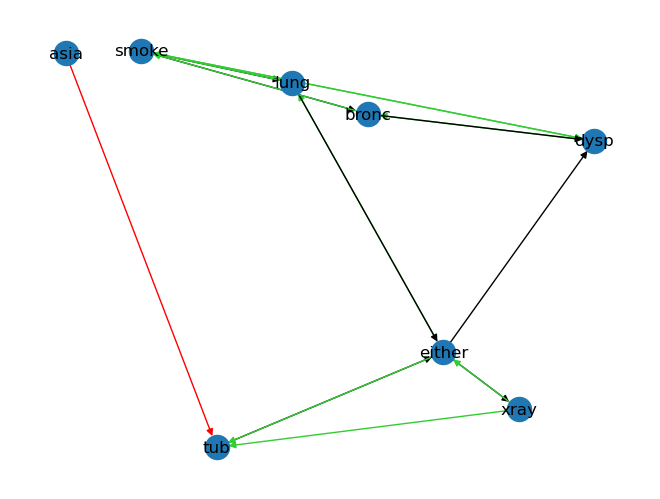

In [11]:
algtime = time.process_time()
weight_num_writer(X, states)
wn_var = np.array(weight_var_importer('weights_num.txt'))
wn_val = np.array(weight_val_importer('weights_num.txt'))

unique_edges = np.unique(wn_var[:,:2],axis=0)
unique_vals = np.zeros(len(unique_edges))
for j in range(len(unique_edges)):
    pair = unique_edges[j]
    unique_vals[j] = (np.max( np.abs( wn_val[np.all(wn_var[:,:2]==pair,axis=1)]) ) )
unique_vals=np.abs(unique_vals)

unique_edges, unique_vals = (lambda x: (unique_edges[x], unique_vals[x]))(np.argsort(unique_vals))

m = binary_search(list(states), unique_edges)
thres = unique_vals[m]

DAG_w2 = triangulation(X, node_list, unique_edges[m:], thres, states)
algtime = time.process_time() - algtime

print("T(s)",algtime,algtime/pc_time)

FN = len(DAGt.edges-DAG_w2.edges) #False Negatives
FP = len(DAG_w2.edges-DAGt.edges) #False Positives
TP = len(DAGt.edges) - FN #True Positives = P - FN
TN = (n_nodes*n_nodes - len(DAGt.edges)) - FP #True Negatives = N - FP

print("FPR", FP/(n_nodes*n_nodes - len(DAGt.edges)) ) #FPR = FP/N
print("FNR", FN/len(DAGt.edges) ) #FNR = FN/P
print("MCC", (TP*TN - FP*FN)/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)) ) #MCC

G = nx.DiGraph()
G.add_edges_from(DAG_w2.edges,color="k")

to_remove = G.edges() - DAGt.edges()
G.remove_edges_from( to_remove )
G.add_edges_from( to_remove ,color="limegreen") #excess
G.add_edges_from(list(DAGt.edges() - G.edges()) ,color="r") #missing

colors = [G[u][v]['color'] for u,v in G.edges()]
#pl.figure(figsize=(20,16))
nx.draw(G,pos=pos,edge_color=colors,with_labels=True)

T(s) 5.205168385 4.166415370442458
FPR 0.1
FNR 0.125
MCC 0.7496587917803454


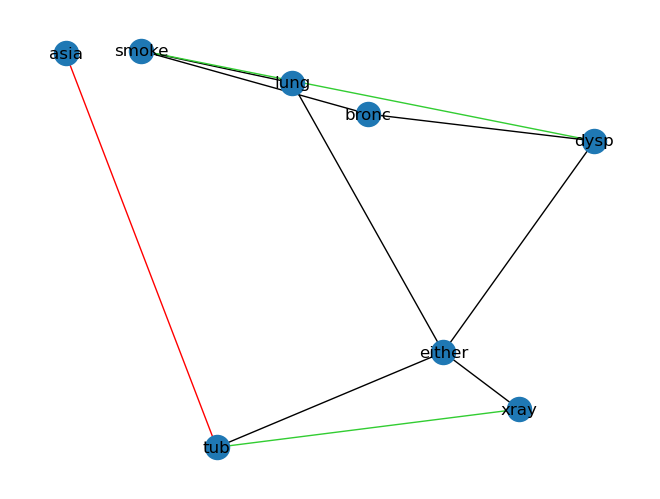

In [12]:
algtime = time.process_time()
weight_num_writer(X, states)
wn_var = np.array(weight_var_importer('weights_num.txt'))
wn_val = np.array(weight_val_importer('weights_num.txt'))

unique_edges = np.unique(wn_var[:,:2],axis=0)
unique_vals = np.zeros(len(unique_edges))
for j in range(len(unique_edges)): #for a given direction, keep the biggest state
    pair = unique_edges[j]
    unique_vals[j] = (np.max( np.abs( wn_val[np.all(wn_var[:,:2]==pair,axis=1)]) ) )
unique_vals=np.abs(unique_vals)
#'''
for j in range(len(unique_edges)): #keep the biggest direction
    pair = unique_edges[j]
    anti_j = np.where(np.all(unique_edges==np.flip(pair),axis=1))[0][0]

    if unique_vals[j] >= unique_vals[anti_j]:
        
        unique_vals[anti_j] = -np.infty
unique_vals, unique_edges = (lambda x: (np.delete(unique_vals,x), np.delete(unique_edges,x,axis=0)))(np.where(unique_vals<0))
#'''
unique_edges, unique_vals = (lambda x: (unique_edges[x], unique_vals[x]))(np.argsort(unique_vals))

m = binary_search(list(states), unique_edges)
thres = unique_vals[m]

DAG_w2 = triangulation_und(X, node_list, unique_edges[m:], thres, states)
algtime = time.process_time() - algtime

print("T(s)",algtime,algtime/pc_skeletime)

FN = len(Gt.edges-DAG_w2.edges) #False Negatives
FP = len(DAG_w2.edges-Gt.edges) #False Positives
TP = len(Gt.edges) - FN #True Positives = P - FN
TN = (n_nodes*(n_nodes-1)/2 - len(Gt.edges)) - FP #True Negatives = N - FP

print("FPR", FP/(n_nodes*(n_nodes-1)/2 - len(Gt.edges)) ) #FPR = FP/N
print("FNR", FN/len(Gt.edges) ) #FNR = FN/P
print("MCC", (TP*TN - FP*FN)/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)) ) #MCC

G = nx.Graph()
G.add_edges_from(DAG_w2.edges,color="k")

to_remove = G.edges() - Gt.edges()
G.remove_edges_from( to_remove )
G.add_edges_from( to_remove ,color="limegreen") #excess
G.add_edges_from(list(Gt.edges() - G.edges()) ,color="r") #missing

colors = [G[u][v]['color'] for u,v in G.edges()]
#pl.figure(figsize=(20,16))
nx.draw(G,pos=pos,edge_color=colors,with_labels=True)

## NIKnee

T(s) 1.782833582000002 0.3451128269064565
FPR 0.0
FNR 0.25
MCC 0.8509629433967631


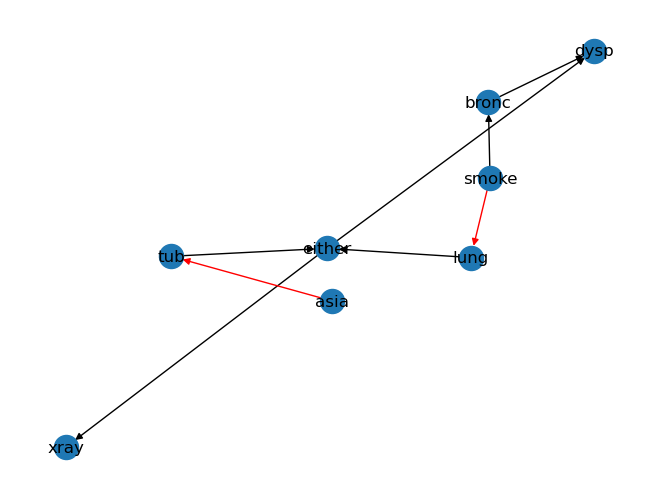

In [13]:
algtime = time.process_time()
weight_num_writer_ord(X, states, order)
wn_var = np.array(weight_var_importer('weights_num.txt'))
wn_val = np.array(weight_val_importer('weights_num.txt'))
    
unique_edges = np.unique(wn_var[:,:2],axis=0)
unique_vals = np.zeros(len(unique_edges))
for j in range(len(unique_edges)):
    pair = unique_edges[j]
    unique_vals[j] = (np.max( np.abs( wn_val[np.all(wn_var[:,:2]==pair,axis=1)]) ) )
unique_vals=np.abs(unique_vals)

unique_edges, unique_vals = (lambda x: (unique_edges[x], unique_vals[x]))(np.argsort(unique_vals))

##Threshold in first step
gcc_nodes=np.zeros(len(unique_edges))
for j in range(len(unique_edges)):
    H = nx.Graph()
    H.add_edges_from(unique_edges[j:])
    gcc_nodes[j] = len(max(nx.connected_components(H),key=len))
del H
m = kneedle.auto_knee(np.column_stack((np.arange(len(gcc_nodes)),gcc_nodes)))
thres = unique_vals[m]

DAG_w2 = triangulation(X, node_list, unique_edges[m:], thres, states)
algtime = time.process_time() - algtime

print("T(s)",algtime,algtime/pc_time)

FN = len(DAGt.edges-DAG_w2.edges) #False Negatives
FP = len(DAG_w2.edges-DAGt.edges) #False Positives
TP = len(DAGt.edges) - FN #True Positives = P - FN
TN = (n_nodes*n_nodes - len(DAGt.edges)) - FP #True Negatives = N - FP

print("FPR", FP/(n_nodes*n_nodes - len(DAGt.edges)) ) #FPR = FP/N
print("FNR", FN/len(DAGt.edges) ) #FNR = FN/P
print("MCC", (TP*TN - FP*FN)/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)) ) #MCC

G = nx.DiGraph()
G.add_edges_from(DAG_w2.edges,color="k")

to_remove = G.edges() - DAGt.edges()
G.remove_edges_from( to_remove )
G.add_edges_from( to_remove ,color="limegreen") #excess
G.add_edges_from(list(DAGt.edges() - G.edges()) ,color="r") #missing

colors = [G[u][v]['color'] for u,v in G.edges()]
#pl.figure(figsize=(20,16))
nx.draw(G,edge_color=colors,with_labels=True)

T(s) 3.750950588000002 0.7260919774457751
FPR 0.07142857142857142
FNR 0.5
MCC 0.42857142857142855


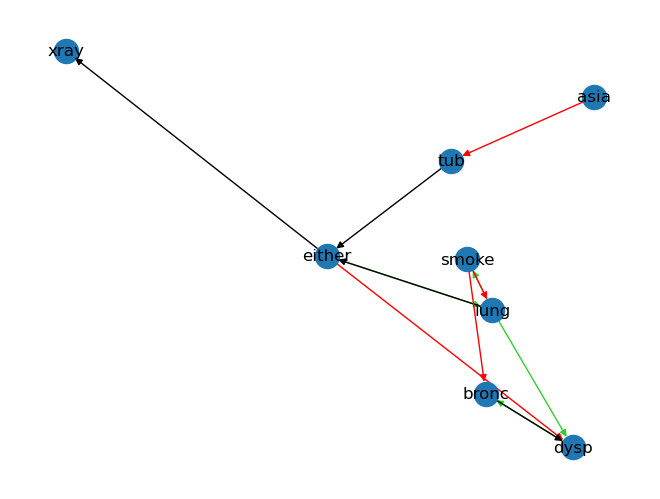

In [14]:
algtime = time.process_time()
weight_num_writer(X, states)
wn_var = np.array(weight_var_importer('weights_num.txt'))
wn_val = np.array(weight_val_importer('weights_num.txt'))
    
unique_edges = np.unique(wn_var[:,:2],axis=0)
unique_vals = np.zeros(len(unique_edges))
for j in range(len(unique_edges)):
    pair = unique_edges[j]
    unique_vals[j] = (np.max( np.abs( wn_val[np.all(wn_var[:,:2]==pair,axis=1)]) ) )
unique_vals=np.abs(unique_vals)

unique_edges, unique_vals = (lambda x: (unique_edges[x], unique_vals[x]))(np.argsort(unique_vals))

##Threshold in first step
gcc_nodes=np.zeros(len(unique_edges))
for j in range(len(unique_edges)):
    H = nx.Graph()
    H.add_edges_from(unique_edges[j:])
    gcc_nodes[j] = len(max(nx.connected_components(H),key=len))
del H
m = kneedle.auto_knee(np.column_stack((np.arange(len(gcc_nodes)),gcc_nodes)))
thres = unique_vals[m]

DAG_w2 = triangulation(X, node_list, unique_edges[m:], thres, states)
algtime = time.process_time() - algtime

print("T(s)",algtime,algtime/pc_time)

FN = len(DAGt.edges-DAG_w2.edges) #False Negatives
FP = len(DAG_w2.edges-DAGt.edges) #False Positives
TP = len(DAGt.edges) - FN #True Positives = P - FN
TN = (n_nodes*n_nodes - len(DAGt.edges)) - FP #True Negatives = N - FP

print("FPR", FP/(n_nodes*n_nodes - len(DAGt.edges)) ) #FPR = FP/N
print("FNR", FN/len(DAGt.edges) ) #FNR = FN/P
print("MCC", (TP*TN - FP*FN)/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)) ) #MCC

G = nx.DiGraph()
G.add_edges_from(DAG_w2.edges,color="k")

to_remove = G.edges() - DAGt.edges()
G.remove_edges_from( to_remove )
G.add_edges_from( to_remove ,color="limegreen") #excess
G.add_edges_from(list(DAGt.edges() - G.edges()) ,color="r") #missing

colors = [G[u][v]['color'] for u,v in G.edges()]
#pl.figure(figsize=(20,16))
nx.draw(G,edge_color=colors,with_labels=True)

T(s) 4.007105977000002 3.2074405088750355
FPR 0.0
FNR 0.375
MCC 0.7372097807744856


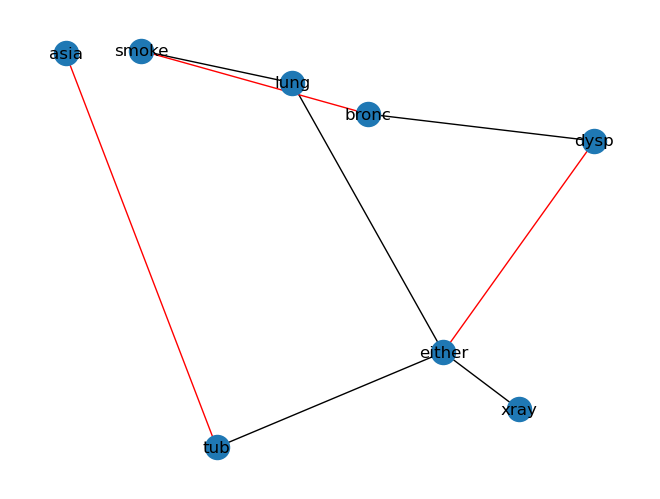

In [15]:
algtime = time.process_time()
weight_num_writer(X, states)
wn_var = np.array(weight_var_importer('weights_num.txt'))
wn_val = np.array(weight_val_importer('weights_num.txt'))

unique_edges = np.unique(wn_var[:,:2],axis=0)
unique_vals = np.zeros(len(unique_edges))
for j in range(len(unique_edges)): #for a given direction, keep the biggest state
    pair = unique_edges[j]
    unique_vals[j] = (np.max( np.abs( wn_val[np.all(wn_var[:,:2]==pair,axis=1)]) ) )
unique_vals=np.abs(unique_vals)
#'''
for j in range(len(unique_edges)): #keep the biggest direction
    pair = unique_edges[j]
    anti_j = np.where(np.all(unique_edges==np.flip(pair),axis=1))[0][0]

    if unique_vals[j] >= unique_vals[anti_j]:
        
        unique_vals[anti_j] = -np.infty
unique_vals, unique_edges = (lambda x: (np.delete(unique_vals,x), np.delete(unique_edges,x,axis=0)))(np.where(unique_vals<0))
#'''
unique_edges, unique_vals = (lambda x: (unique_edges[x], unique_vals[x]))(np.argsort(unique_vals))

gcc_nodes=np.zeros(len(unique_edges))
for j in range(len(unique_edges)):
    H = nx.Graph()
    H.add_edges_from(unique_edges[j:])
    gcc_nodes[j] = len(max(nx.connected_components(H),key=len))
del H
m = kneedle.auto_knee(np.column_stack((np.arange(len(gcc_nodes)),gcc_nodes)))
thres = unique_vals[m]

DAG_w2 = triangulation_und(X, node_list, unique_edges[m:], thres, states)
algtime = time.process_time() - algtime

print("T(s)",algtime,algtime/pc_skeletime)

FN = len(Gt.edges-DAG_w2.edges) #False Negatives
FP = len(DAG_w2.edges-Gt.edges) #False Positives
TP = len(Gt.edges) - FN #True Positives = P - FN
TN = (n_nodes*(n_nodes-1)/2 - len(Gt.edges)) - FP #True Negatives = N - FP

print("FPR", FP/(n_nodes*(n_nodes-1)/2 - len(Gt.edges)) ) #FPR = FP/N
print("FNR", FN/len(Gt.edges) ) #FNR = FN/P
print("MCC", (TP*TN - FP*FN)/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)) ) #MCC

G = nx.Graph()
G.add_edges_from(DAG_w2.edges,color="k")

to_remove = G.edges() - Gt.edges()
G.remove_edges_from( to_remove )
G.add_edges_from( to_remove ,color="limegreen") #excess
G.add_edges_from(list(Gt.edges() - G.edges()) ,color="r") #missing

colors = [G[u][v]['color'] for u,v in G.edges()]
#pl.figure(figsize=(20,16))
nx.draw(G,pos=pos,edge_color=colors,with_labels=True)